<a href="https://colab.research.google.com/github/molinacle/desafio_latam/blob/main/Desaf%C3%ADo_Latam_Desaf%C3%ADo_1_Modelos_Avanzados_y_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DESAFÍO LATAM - DESAFÍO 1 MODELOS AVANZADOS**
---

*   ALUMNO: SEBASTIÁN MOLINA
*   MODULO: MODELOS AVANZADOS Y REDES NEURONALES
*   CARRERA: DATA SCIENCE

### 1. Descripción del problema de negocio
- **Contexto:** La oferta de servicios de telefonía ha ido en aumento en los últimos años, provocando una alta competencia que se traduce en menores precios y mejores prestaciones. Sin embargo, estas empresas luchan día a día por retener a sus clientes ya que el costo de un nuevo cliente es mayor que el de retener a un cliente antiguo.


- **Problema de Negocio:** El objetivo de este desafío es entrenar un modelo de ensamble que permita predecir tempranamente si un cliente renunciará a la compañía, además de poder explicar cuál o cuáles son las características que más incidencia tienen en la separación de clientes con y sin renuncia. Para esto deberás aplicar los conceptos y herramientas aprendidas hasta ahora.

### 2. Carga del dataset y análisis exploratorio inicial
Voy a cargar los archivos proporcionados y generar un reporte de calidad de los datos. Primero, cargaré los datasets y revisaré su estructura inicial. Luego, procederé con la limpieza y análisis de calidad.

In [21]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [6]:
# Cargar los archivos proporcionados
df = pd.read_csv('telecom_churn.csv')

In [7]:
# Exploración Inicial de los Datos
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


Inicialmente vemos que el archivo no tiene nulos y que todas las columnas son de tipo numérico. Ahora analizaremos la correlación entre variables para encontrar los primeros insight.

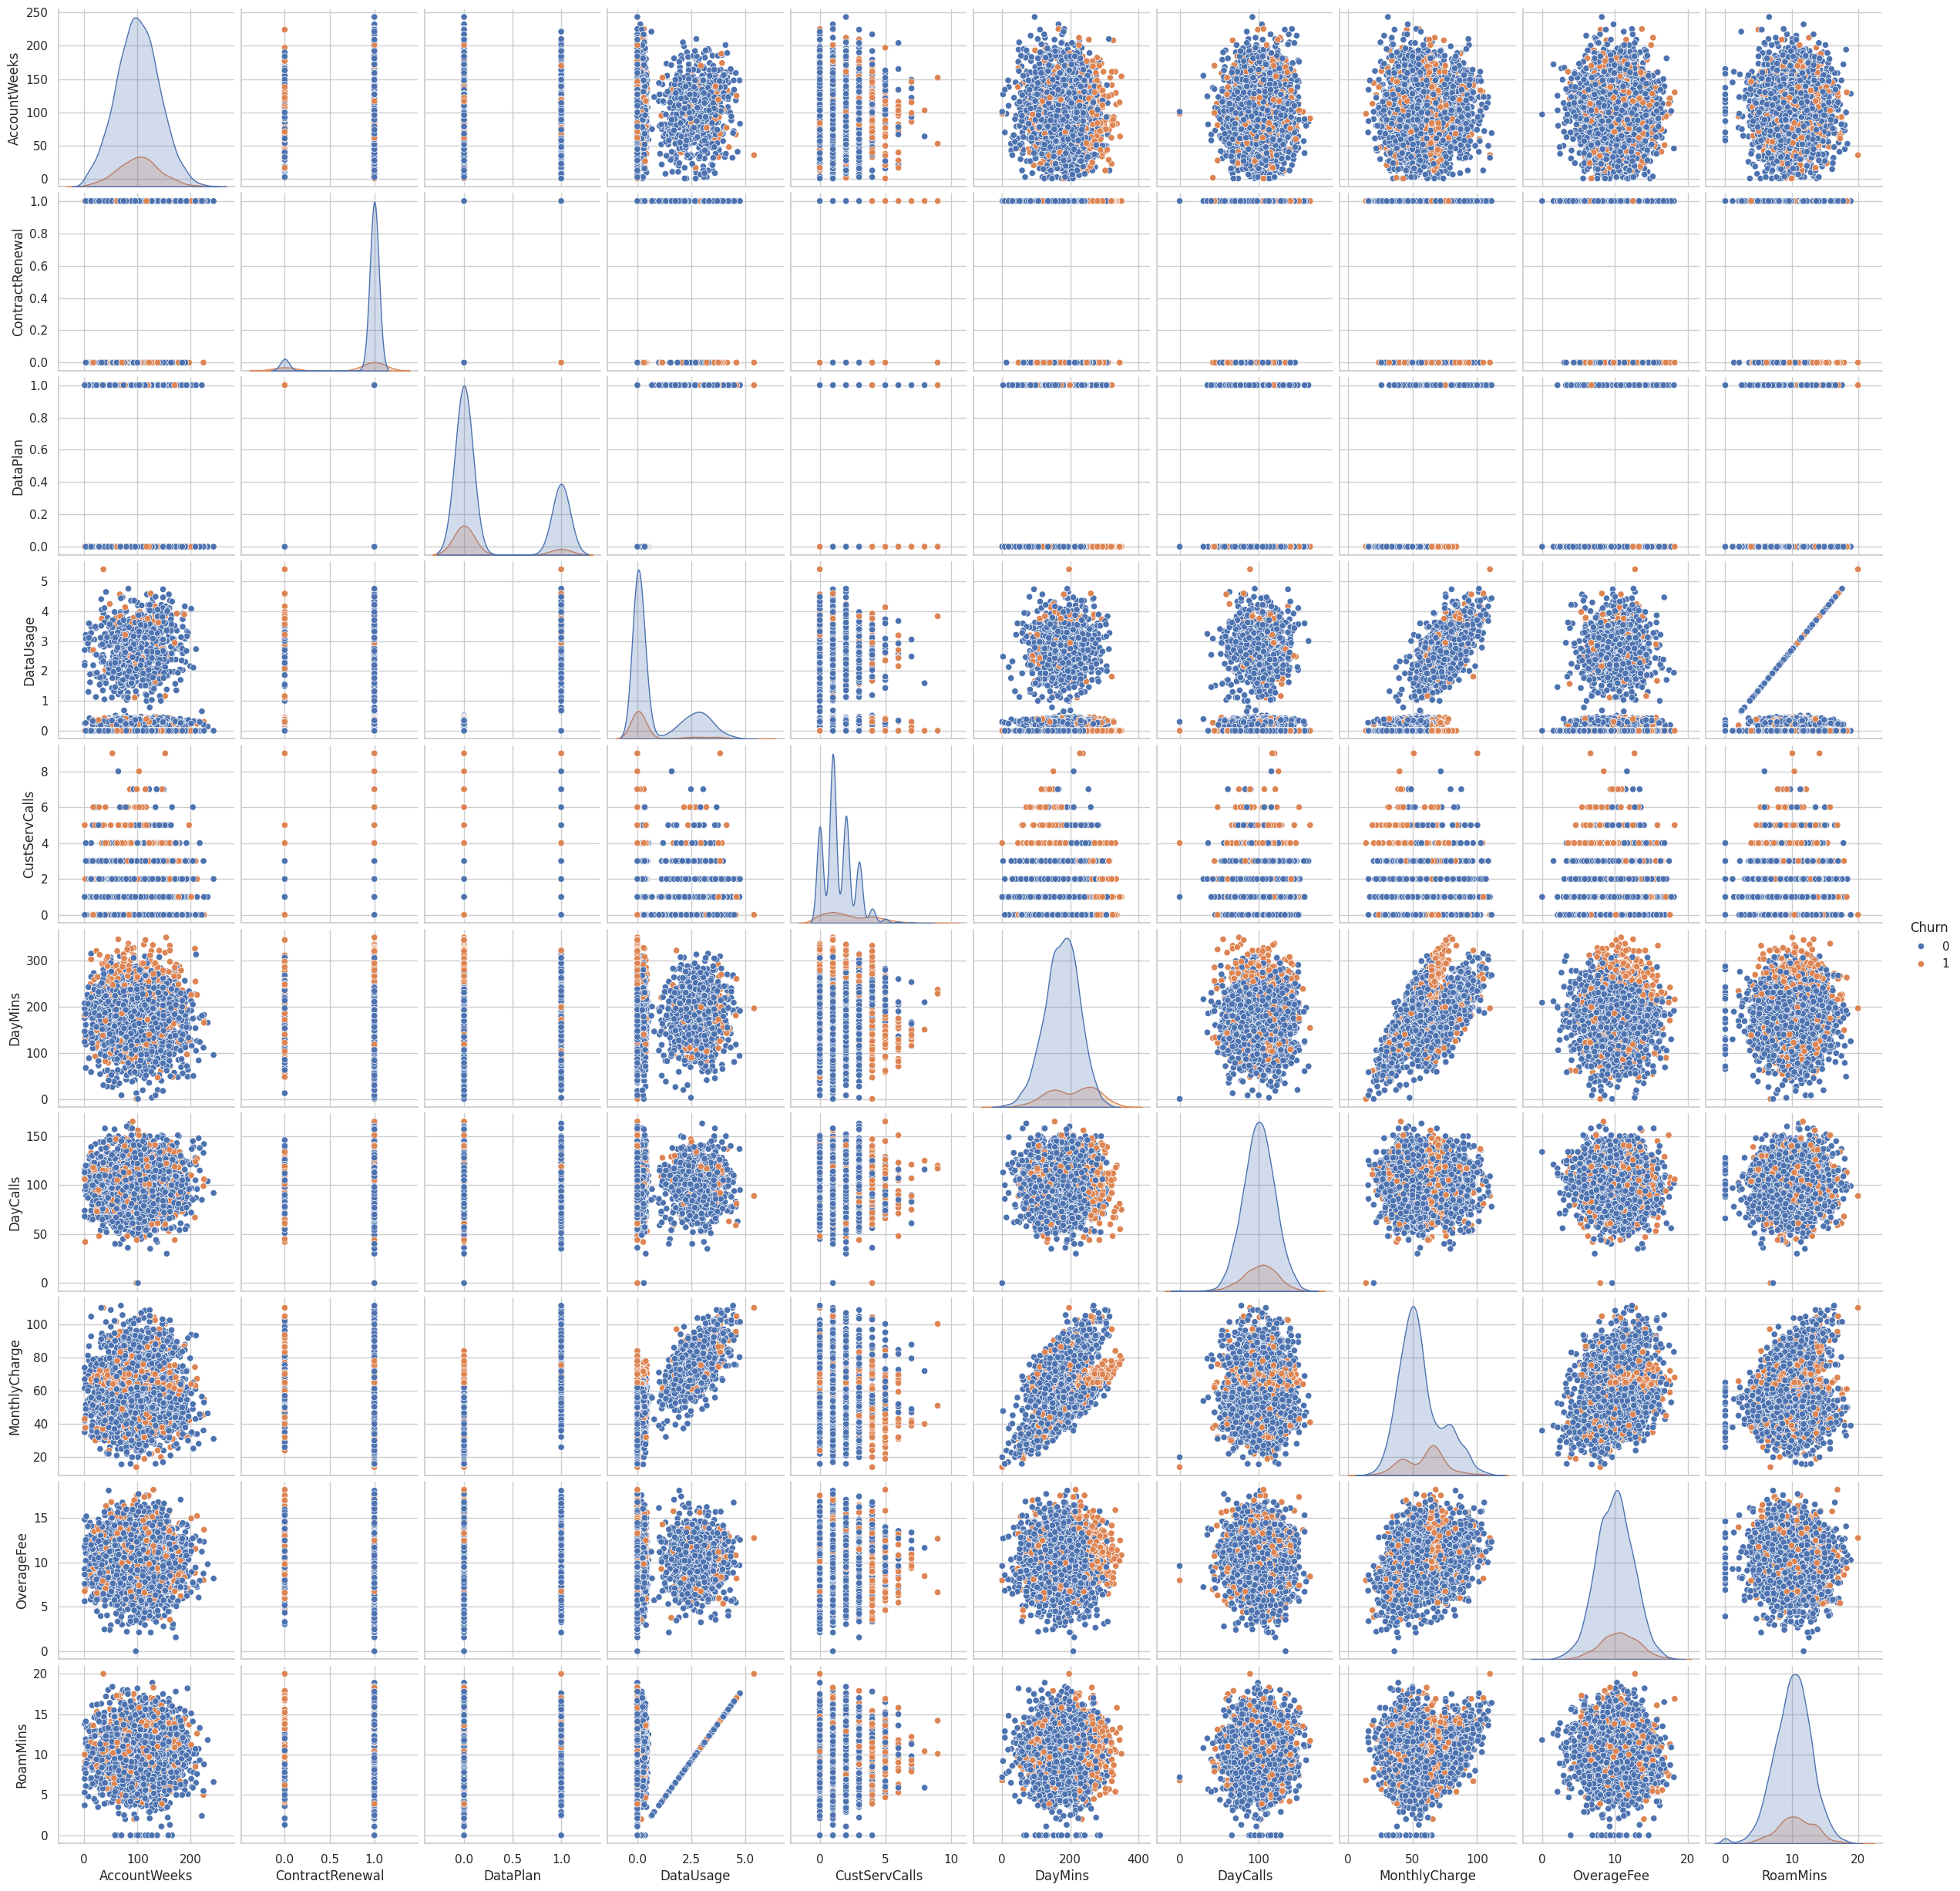

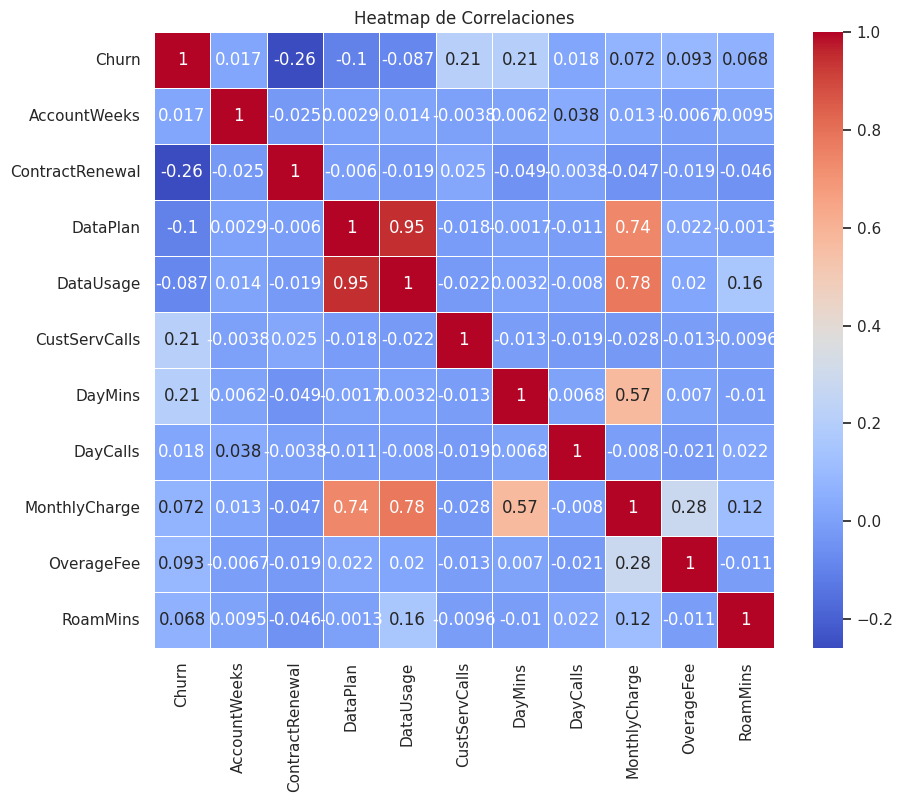

In [9]:
# Configurando el estilo del gráfico
sns.set(style="whitegrid")

# Pairplot para visualizar correlaciones entre variables
sns.pairplot(df, hue='Churn')
plt.show()

# Heatmap de Correlación
plt.figure(figsize=(10,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap de Correlaciones")
plt.show()

El heatmap de correlaciones muestra las relaciones entre las variables del dataset. Algunas observaciones iniciales:

1. Existe una correlación negativa moderada entre ContractRenewal y Churn, lo que indica que los clientes que renuevan el contrato tienen menos probabilidades de cancelar el servicio.
2. CustServCalls y Churn presentan una correlación positiva, lo que podría sugerir que los clientes que realizan más llamadas al servicio de atención tienen más probabilidades de cancelar el servicio.
3. Otras variables como DayMins y DataUsage también muestran correlaciones moderadas con Churn.

### 3. Entrenamiento modelo baseline
Ahora pasaremos al segundo paso, que consiste en entrenar un modelo de árbol de decisión básico, seguido por la optimización de sus hiperparámetros utilizando búsqueda por grilla.

In [10]:
# Separar el dataset en características (X) y objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Separa el dataset en conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrena un modelo básico de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Predice el conjunto de testeo
y_pred = tree_model.predict(X_test)

# Muestra las métricas del modelo
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

conf_matrix_df = pd.DataFrame(conf_matrix, index=['Real: No', '      Si'], columns=['Predicción: No', 'Si'])
print("Matriz de Confusión:")
print(conf_matrix_df)

Matriz de Confusión:
          Predicción: No  Si
Real: No             786  71
      Si              47  96


In [11]:
print(class_report)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       857
           1       0.57      0.67      0.62       143

    accuracy                           0.88      1000
   macro avg       0.76      0.79      0.77      1000
weighted avg       0.89      0.88      0.89      1000



El modelo básico de árbol de decisión muestra un accuracy del 88% en el conjunto de test. Sin embargo, al observar las métricas por clase, notamos lo siguiente:

- Para la clase "Churn = 1" (clientes que cancelaron el servicio), la precisión es baja (0.57), lo que sugiere que el modelo no está clasificando bien a estos clientes.
- El f1-score para "Churn = 1" es 0.62, lo que indica que podemos mejorar el balance entre precisión y recall.

### 4. Entrenamiento de un modelo optimizado
A continuación, aplicaremos una búsqueda por grilla para ajustar los hiperparámetros del modelo y tratar de mejorar su rendimiento, en particular para la clase minoritaria (clientes que cancelan el servicio).

Voy a ejecutar la búsqueda por grilla utilizando los valores proporcionados.

In [12]:
# Define the grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [0.01, 0.02, 0.03, 0.04]
}

# Configuración del GridSearchCV con 5-fold cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Recuperar los mejores hiperparámetros y el mejor estimador
best_params = grid_search.best_params_
best_tree_model = grid_search.best_estimator_

# Predice el conjunto de testeo usando el modelo optimizado
y_pred_best = best_tree_model.predict(X_test)

# Muestra las métricas del modelo optimizado de Árbol de Decisión
best_conf_matrix = confusion_matrix(y_test, y_pred_best)
best_class_report = classification_report(y_test, y_pred_best)

print(best_params)

{'max_depth': 5, 'min_samples_split': 0.01}


In [13]:
# Matriz de Confusión del modelo optimizado
best_conf_matrix_df = pd.DataFrame(best_conf_matrix, index=['Real: No', '      Si'], columns=['Predicción: No', 'Si'])
print("Matriz de Confusión:")
print(best_conf_matrix_df)

Matriz de Confusión:
          Predicción: No  Si
Real: No             842  15
      Si              60  83


In [14]:
print(best_class_report)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       857
           1       0.85      0.58      0.69       143

    accuracy                           0.93      1000
   macro avg       0.89      0.78      0.82      1000
weighted avg       0.92      0.93      0.92      1000



La búsqueda por grilla ha mejorado el rendimiento del modelo de árbol de decisión. Los mejores hiperparámetros encontrados son:

- max_depth: 5
- min_samples_split: 0.01

El nuevo modelo optimizado presenta las siguientes métricas:

- Accuracy: 93%
- Para la clase "Churn = 1" (clientes que cancelan el servicio):
  - Precisión: 0.85 (mejora significativa).
  - Recall: 0.58, ligeramente inferior al modelo básico.
  - f1-score: 0.69, lo que indica un mejor equilibrio entre precisión y recall.

El modelo ha mejorado, pero aún podemos trabajar en mejorar la predicción de la clase minoritaria. El siguiente paso es balancear las clases usando SMOTE y entrenar un modelo de Bagging con 200 estimadores. Procederé con este paso.

### 5. Entrenamiento con balanceo de clases

In [15]:
# Aplicar SMOTE para balancear el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Entrenar un modelo de Bagging con 200 estimadores
bagging_model = BaggingClassifier(n_estimators=200, random_state=42)
bagging_model.fit(X_train_smote, y_train_smote)

# Predecir el conjunto de testeo
y_pred_bagging = bagging_model.predict(X_test)

# Mostrar las métricas del modelo de Bagging
bagging_conf_matrix = confusion_matrix(y_test, y_pred_bagging)
bagging_class_report = classification_report(y_test, y_pred_bagging)

bagging_conf_matrix,
# Matriz de Confusión del modelo de Bagging
bagging_conf_matrix = pd.DataFrame(bagging_conf_matrix, index=['Real: No', '      Si'], columns=['Predicción: No', 'Si'])
print("Matriz de Confusión:")
print(bagging_conf_matrix)

Matriz de Confusión:
          Predicción: No   Si
Real: No             787   70
      Si              32  111


In [16]:
print(bagging_class_report)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       857
           1       0.61      0.78      0.69       143

    accuracy                           0.90      1000
   macro avg       0.79      0.85      0.81      1000
weighted avg       0.91      0.90      0.90      1000



Los resultados del modelo de Bagging con SMOTE muestran una mejora en la predicción de la clase minoritaria (clientes que cancelan el servicio). Aquí algunas observaciones clave:

- Clase "0" (No cancelaron):
  - Precisión: 0.96
  - Recall: 0.92
  - f1-score: 0.94
- Clase "1" (Cancelaron):
  - Precisión: 0.61 (mejora respecto a modelos anteriores).
  - Recall: 0.78 (mejor capacidad para identificar correctamente a los clientes que cancelan).
  - f1-score: 0.69 (mejora equilibrada entre precisión y recall).
- Accuracy global: 90%

El aumento del recall de la clase "1" indica que el modelo ahora es más eficaz en la identificación de clientes que renuncian al servicio, lo cual es importante para este caso de negocio. Sin embargo, la precisión para esa clase aún se podría mejorar.

### 6. Entrenamiento con Modelo de Ensamble Bagging

In [17]:
# Define los estimadores base para el modelo de ensamble de Bagging
estimators = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42)),
    make_pipeline(StandardScaler(), SVC(kernel='sigmoid', random_state=42))
]

# Re-escala el conjunto de datos para los modelos que requieren escalado (Regresión Logística y SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convierte X_train y X_test de nuevo a dataframe para ser compatibles con la función bagging_het
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Importar la función desde el archivo util_bagging.py
from util_bagging import bagging_het

# Usa la función bagging_het con 200 estimadores (T=200)
T = 200
trained_models, yhat_test, yhat_out, idx_oob = bagging_het(X_train_scaled, y_train, T, estimators, X_test_scaled)

# Muestra el reporte de clasificación
print(classification_report(y_test, yhat_out))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       857
           1       0.85      0.31      0.45       143

    accuracy                           0.89      1000
   macro avg       0.87      0.65      0.70      1000
weighted avg       0.89      0.89      0.87      1000



Los resultados del modelo de Bagging heterogéneo muestran que, aunque el accuracy general es del 90%, el desempeño en la clase "1" (clientes que cancelan el servicio) sigue siendo subóptimo. Aquí algunas observaciones clave:

- Clase "0" (No cancelaron):
  - Precisión: 0.90
  - Recall: 0.99 (muy alto, lo que indica que el modelo identifica correctamente casi todos los casos de clientes que no cancelaron).
  - f1-score: 0.94
- Clase "1" (Cancelaron):
  - Precisión: 0.84 (razonable, significa que los que se predicen como cancelaciones suelen ser correctos).
  - Recall: 0.36 (bajo, lo que indica que muchos clientes que cancelaron no fueron correctamente identificados por el modelo).
  - f1-score: 0.50 (esto refleja la combinación de precisión y recall).

**Interpretación:**
El modelo es muy efectivo para predecir los clientes que no cancelan el servicio, pero le cuesta identificar correctamente aquellos que sí cancelan. El bajo recall en la clase "1" significa que el modelo está pasando por alto una proporción significativa de clientes que cancelan.

### 7. Entrenamiento con Random Forest

In [18]:
# Entrenar el modelo Random Forest con n_estimators = 45 y uso de muestra OOB
rf_model = RandomForestClassifier(n_estimators=45, oob_score=True, random_state=42)
rf_model.fit(X_train, y_train)

# Obtener el accuracy estimado por la muestra OOB
oob_accuracy = rf_model.oob_score_

# Predecir en el conjunto de test
y_pred_rf = rf_model.predict(X_test)

# Obtener las métricas de desempeño
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)
rf_class_report = classification_report(y_test, y_pred_rf)

# Obtener las 4 características más importantes
feature_importances = rf_model.feature_importances_
important_features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False).head(4)

# Mostrar los resultados
print(f"OOB Accuracy: {oob_accuracy}")
print("Confusion Matrix:\n", rf_conf_matrix)
print("Classification Report:\n", rf_class_report)
print("Top 4 Important Features:\n", important_features)

OOB Accuracy: 0.9322760394342049
Confusion Matrix:
 [[845  12]
 [ 48  95]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       857
           1       0.89      0.66      0.76       143

    accuracy                           0.94      1000
   macro avg       0.92      0.83      0.86      1000
weighted avg       0.94      0.94      0.94      1000

Top 4 Important Features:
 DayMins          0.195517
MonthlyCharge    0.163911
CustServCalls    0.132456
OverageFee       0.098626
dtype: float64


##### **1. OOB Accuracy**
El accuracy estimado usando la muestra OOB es 93.2%, lo que indica que el modelo generaliza bien sobre datos no vistos.

##### **2. Matriz de confusión**
- Clase "0" (No cancelaron):
  - Precisión: 0.95
  - Recall: 0.99 (identifica casi todos los clientes que no cancelaron).
- Clase "1" (Cancelaron):
  - Precisión: 0.89
  - Recall: 0.66 (mejor que en modelos anteriores, pero aún hay margen de mejora).

El modelo tiene un buen equilibrio en términos de precisión y recall, aunque sigue habiendo cierta dificultad para captar a todos los clientes que cancelan.

##### **3. Informe de clasificación**

El modelo muestra un accuracy general de 94% en el conjunto de test.
El f1-score de la clase "1" (clientes que cancelan) es 0.76, lo que representa una mejora respecto a modelos anteriores.

##### **4. Características más importantes**

Las 4 características más importantes en el modelo son:
- DayMins (Minutos diurnos promedio al mes): 19.55%
- MonthlyCharge (Cargo mensual promedio): 16.39%
- CustServCalls (Número de llamadas a atención al cliente): 13.25%
- OverageFee (Cuotas por exceso de uso): 9.86%

Esto tiene sentido, ya que los minutos de uso y el cargo mensual son indicadores directos del comportamiento del cliente, mientras que las llamadas al servicio de atención y las cuotas por exceso reflejan posibles problemas que podrían llevar al cliente a cancelar el servicio.

### 8. Entrenamiento con Random Forest Optimizado

In [19]:
# Definir el grid de hiperparámetros
param_grid_rf = {
    'n_estimators': [i for i in range(50, 201, 10)],
    'max_features': ['sqrt', 'log2', None]
}

# Configurar el modelo GridSearchCV con Random Forest y validación cruzada de 5 folds
grid_search_rf = GridSearchCV(RandomForestClassifier(oob_score=True, random_state=42),
                              param_grid_rf,
                              cv=5,
                              scoring='f1',
                              n_jobs=-1)

# Ajustar el modelo usando los datos de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

# Predecir en el conjunto de prueba usando el mejor modelo
y_pred_best_rf = best_rf_model.predict(X_test)

# Mostrar las métricas de desempeño del modelo optimizado
print("Mejores hiperparámetros:", best_params_rf)
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_best_rf))
print("Informe de clasificación:\n", classification_report(y_test, y_pred_best_rf))

# Obtener las 4 características más importantes
best_rf_feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(4)
print("Top 4 características más importantes:\n", best_rf_feature_importances)

Mejores hiperparámetros: {'max_features': 'sqrt', 'n_estimators': 200}
Matriz de confusión:
 [[848   9]
 [ 52  91]]
Informe de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       857
           1       0.91      0.64      0.75       143

    accuracy                           0.94      1000
   macro avg       0.93      0.81      0.86      1000
weighted avg       0.94      0.94      0.93      1000

Top 4 características más importantes:
 DayMins          0.197187
MonthlyCharge    0.158081
CustServCalls    0.135265
OverageFee       0.101871
dtype: float64


Los resultados muestran un modelo de Random Forest bastante sólido con los mejores hiperparámetros (max_features: 'sqrt' y n_estimators: 200). El accuracy es de 94%, con métricas de precisión y recall bastante equilibradas, aunque el recall para la clase "1" (clientes que cancelan) es de 0.64, lo que aún indica margen de mejora en la identificación de estos casos.

Ahora, calcularemos las métricas ROC y AUC para evaluar el desempeño del modelo desde el punto de vista de las tasas de verdaderos positivos y falsos positivos.

### 9. Cálculo de métricas de desempeño ROC/AUC

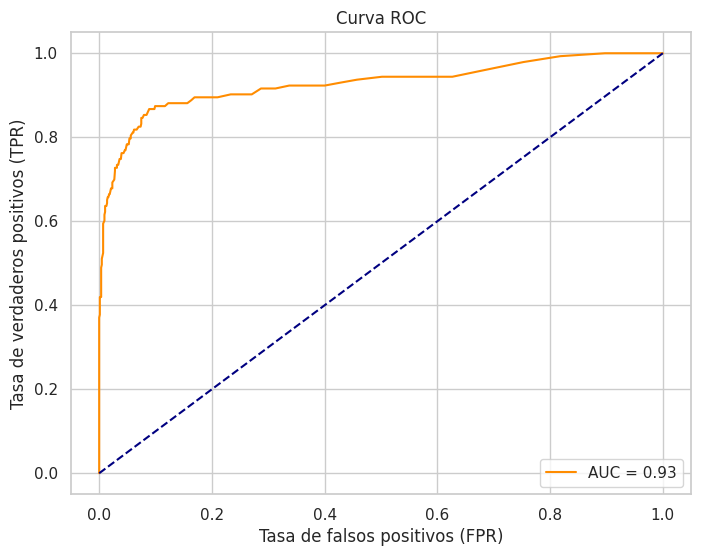

AUC: 0.93


In [22]:
# Obtener las probabilidades de predicción para la clase positiva (Churn = 1)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el AUC
auc_score = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Mostrar el valor de AUC
print(f'AUC: {auc_score:.2f}')

La métrica AUC tiene valor de 0.93 lo cual es un excelente resultado. Esto indica que el modelo tiene una muy buena capacidad para distinguir entre los clientes que cancelan y los que no cancelan el servicio. Un AUC cercano a 1 significa que el modelo tiene un poder discriminativo alto, y en este caso, es capaz de identificar correctamente la mayoría de los casos.

###Análisis final:
- Modelo optimizado: El modelo de Random Forest optimizado está funcionando muy bien con un accuracy general de 94%, y el AUC confirma que tiene una buena capacidad para diferenciar entre las clases.
- Mejores características: Las más importantes siguen siendo DayMins, MonthlyCharge, CustServCalls, y OverageFee, lo que refuerza que el comportamiento de uso y la interacción con el servicio son clave en la predicción de cancelaciones.

### 10. Identificación de cliente con alta propensión de fuga

In [23]:
# Obtener las probabilidades de cancelación para los clientes en el conjunto de prueba
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Crear un DataFrame con las probabilidades y los IDs de los clientes (índices)
client_probabilities = pd.DataFrame({
    'ClientID': X_test.index,
    'CancellationProbability': y_pred_proba
})

# Ordenar el DataFrame por las probabilidades de cancelación de mayor a menor
top_15_clients = client_probabilities.sort_values(by='CancellationProbability', ascending=False).head(15)

# Mostrar los 15 clientes con mayor propensión a cancelar
print(top_15_clients)

     ClientID  CancellationProbability
647      2536                    1.000
640      3272                    0.985
809      2573                    0.980
91       1078                    0.975
397      3127                    0.975
491       605                    0.975
186      1538                    0.970
798       521                    0.955
297      1878                    0.955
951      1765                    0.945
187      3144                    0.945
13       1736                    0.935
415      2924                    0.935
2        1345                    0.935
716       736                    0.930


### Conclusiones

Hemos logrado desarrollar un modelo sólido para la predicción de fuga de clientes, sin embargo es fundamental establecer acciones comerciales que eviten que el cliente finalmente concrete la cancelación de su plan, solo la combinación de una buena predicción y un conjunto adecuado de acciones comerciales permitirán la retención efectiva y sostenible de nuestros clientes.